In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from scipy.integrate import solve_ivp
import mpl_toolkits.mplot3d.axes3d as p3

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import datafold.dynfold as dfold
from datafold.dynfold import LocalRegressionSelection
from datafold.dynfold import DiffusionMaps
from datafold.utils.plot import plot_pairwise_eigenvector
import datafold.pcfold as pfold
from datafold.pcfold import PCManifold, TSCDataFrame 
from datafold.pcfold.kernels import GaussianKernel
from sklearn import (manifold, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
from time import time


%load_ext autoreload
%autoreload 2

In [2]:
# Prepare train and test data
batch_size = 1280

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', 
                            train=True,
                            download=True, 
                            transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = datasets.CIFAR10(root='./data',
                           train=False,
                           download=True,
                           transform=transform)

testloader = DataLoader(testset,
                        batch_size=batch_size,
                        shuffle=False, num_workers=2)

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize Data

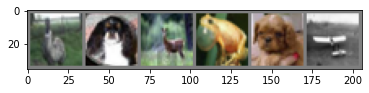

 bird   dog  deer  frog   dog plane


In [3]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:6]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(6)))

In [4]:
images = images.numpy()
labels = labels.numpy()

In [31]:
images.shape

(1280, 3, 32, 32)

In [33]:
images_flat = images.reshape((batch_size, -1))

In [48]:
images_flat

array([[-0.5529412 , -0.56078434,  0.2941177 , ..., -0.56078434,
        -0.5686275 , -0.5372549 ],
       [-0.54509807, -0.23921567,  0.03529418, ..., -0.49019605,
        -0.19215685,  0.03529418],
       [-0.8980392 , -0.96862745, -0.8980392 , ..., -0.0745098 ,
        -0.01960784, -0.14509803],
       ...,
       [ 1.        ,  0.99215686,  0.99215686, ...,  0.99215686,
         0.99215686,  0.99215686],
       [-0.1372549 , -0.10588235, -0.09803921, ..., -0.25490195,
        -0.3490196 , -0.29411763],
       [ 0.5372549 ,  0.4431373 ,  0.3803922 , ..., -0.7176471 ,
        -0.5764706 , -0.5294118 ]], dtype=float32)

In [30]:
X = trainset.data[:1280]
y = trainset.targets[:1280]
X = X.reshape(1280, -1)

In [49]:
X

array([[ 59,  62,  63, ..., 123,  92,  72],
       [154, 177, 187, ..., 143, 133, 144],
       [255, 255, 255, ...,  80,  86,  84],
       ...,
       [175, 180, 181, ..., 195, 196, 196],
       [206, 215, 237, ..., 135, 157,  86],
       [187, 176, 170, ..., 177, 166, 162]], dtype=uint8)

In [19]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)    

In [23]:
def plot_3D_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    ax.scatter(*X.T, c=plt.cm.Set1(y / 10.))

    if title is not None:
        ax.set_title(title)

Computing PCA projection


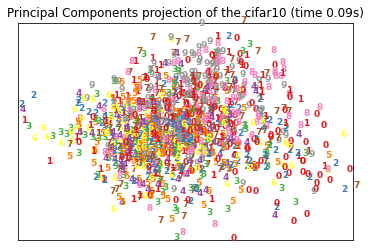

In [66]:
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(images_flat)
plot_embedding(X_pca, labels,
               "Principal Components projection of the cifar10 (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


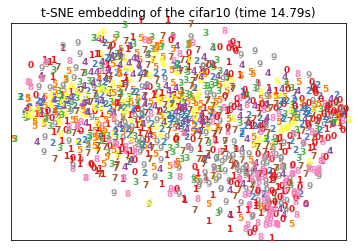

In [65]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(images_flat)

plot_embedding(X_tsne, labels,
               "t-SNE embedding of the cifar10 (time %.2fs)" %
               (time() - t0))

In [62]:
X_pcm = pfold.PCManifold(images_flat)
X_pcm.optimize_parameters(result_scaling=2)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

epsilon=362.34296201756956, cut-off=81.69824981689453


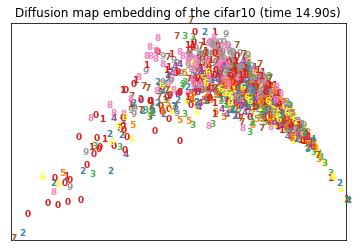

In [64]:
t0 = time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon), 
                     n_eigenpairs=10, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap = dmap.fit(X_pcm)
dmap = dmap.set_coords([1, 2])
X_dmap = dmap.transform(X_pcm)

# Mapping of diffusion maps
plot_embedding(X_dmap, labels, title="Diffusion map embedding of the cifar10 (time %.2fs)" % (time() - t0))